In [1]:
# %matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
import cv2
import imageio
import scipy.io as sio

In [2]:
plate = 13
date_init = datetime(2020,7,1,19,57)
dates_datetime = [date_init+timedelta(hours=4)*i for i in range(24)]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime]

In [21]:
tabs_labeled=[]
for date in dates:
    tabs_labeled.append(pd.read_csv(get_path(date,plate,True,extension='_full_labeled.csv'),
                                    converters={'origin_pos' : transform_list,'end_pos' : transform_list,'pixel_list' : ast.literal_eval}))

In [9]:
from_tip_growth_pattern=[]
for date in dates[:-1]:
    from_tip_growth_pattern.append(from_connection_tab(pd.read_csv(get_path(date,plate,True,extension='_connection.csv'))))

In [22]:
tabs=[]
for date in dates:
    tabs.append(pd.read_csv(get_path(date,plate,True,extension='_full_labeled_matlab.csv'),
                                    converters={'origin_pos' : transform_list,'end_pos' : transform_list,'pixel_list' : ast.literal_eval}))

In [23]:
tabs_raw=[]
for date in dates:
    tabs_raw.append(pd.read_csv(get_path(date,plate,True,extension='_raw_aligned_skeleton.csv'),
                                    converters={'origin_pos' : transform_list,'end_pos' : transform_list,'pixel_list' : ast.literal_eval}))

In [24]:
for i, date in enumerate(dates):
    tabs_labeled[i].to_csv(f'Data/graph_{date}_{plate}_full_labeled.csv')
    tabs[i].to_csv(f'Data/graph_{date}_{plate}_full_labeled_matlab.csv')
    tabs_raw[i].to_csv(f'Data/graph_{date}_{plate}_raw_aligned_skeleton.csv')
    sio.savemat(f'Data/graph_{date}_{plate}_full_labeled.mat', {name: col.values for name, col in tabs_labeled[i].items()})

In [25]:
from_tip_growth_pattern_tab=[]
for date in dates[:-1]:
    from_tip_growth_pattern_tab.append(pd.read_csv(get_path(date,plate,True,extension='_connection.csv')))
for i, date in enumerate(dates[:-1]):
    from_tip_growth_pattern_tab[i].to_csv(f'Data/connection_{date}_{plate}.csv')
# from_tip_growth_pattern=[]
# for i in range(len(from_tip_growth_pattern_tab)):
#     from_tip_growth_pattern.append(from_connection_tab(from_tip_growth_pattern_tab[i]))

In [10]:
tabs_labeled=[]
for date in dates:
    tabs_labeled.append(pd.read_csv(f'Data/graph_{date}_{plate}_full_labeled.csv',
                                    converters={'origin_pos' : transform_list,'end_pos' : transform_list,'pixel_list' : ast.literal_eval}))

In [11]:
nx_graphs=[]
poss=[]
for tab in tabs_labeled:
    nx_graph,pos=generate_nx_graph(tab,labeled=True)
    nx_graphs.append(nx_graph)
    poss.append(pos)

In [12]:
nx_graph_clean=[]
for graph in nx_graphs:
    S = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    len_connected=[len(nx_graph.nodes) for nx_graph in S]
    nx_graph_clean.append(S[np.argmax(len_connected)])

In [13]:
skeletons=[]
for nx_graph in nx_graph_clean:
    skeletons.append(generate_skeleton(nx_graph,dim=(20800, 46000)))

In [14]:
factor = 5
final_pictures = [compress_skeleton(skeletons[i],factor) for i in range(len(skeletons))]

In [34]:
connections = [c[0] for c in from_tip_growth_pattern]
growth_patterns = [c[1] for c in from_tip_growth_pattern]

In [16]:
growths = [{tip : sum([len(branch) for branch in growth_pattern[tip]]) for tip in growth_pattern.keys()} for growth_pattern in growth_patterns]

In [28]:
def pinpoint_anastomosis(nx_graph_tm1,nx_grapht,from_tip):
    anastomosis=[]
    origins=[]
    tips = [node for node in nx_graph_tm1.nodes if nx_graph_tm1.degree(node)==1]
    def count_neighbors_is_from_root(equ_list,nx_graph,root):
        count=0
        for neighbor in nx_graph.neighbors(root):
            if neighbor in equ_list:
                count+=1
        return(count)
    for tip in tips:
#         print(tip)
        consequence = from_tip[tip]
        for node in consequence:
            if node in nx_grapht.nodes and nx_grapht.degree(node)>=3 and count_neighbors_is_from_root(consequence,nx_grapht,node)<2:
#                 if node==2753:
#                     print(count_neighbors_is_from_root(consequence,nx_grapht,node))
#                     print(list(nx_grapht.neighbors(node)))
                anastomosis.append(node)
                origins.append(tip)
    return(anastomosis,origins)

In [30]:
def find_origin_tip(node,from_tip):
    for tip in from_tip.keys():
        if node in from_tip[tip]:
            return(tip)

In [36]:
anastomosiss=[pinpoint_anastomosis(nx_graph_clean[i],nx_graph_clean[i+1], connections[i])[0] for i in range (len(dates)-1)]
origins=[pinpoint_anastomosis(nx_graph_clean[i],nx_graph_clean[i+1], connections[i])[1] for i in range (len(dates)-1)]

In [ ]:
growing_tips=[[node for node in growths[i].keys() if growths[i][node]>=20] for i in range(len(growths))]

In [18]:
degree3_nodes = [[node for node in nx_graph.nodes if nx_graph.degree(node)>=3] for nx_graph in nx_graph_clean]

In [19]:
plot_t_tp1(degree3_nodes[t],degree3_nodes[tp1],poss[t],poss[tp1],final_pictures[t],final_pictures[tp1],compress=5)

NameError: name 't' is not defined

In [19]:
t=1
tp1=t+1

In [ ]:
plot_t_tp1(origins[t],anastomosiss[t],poss[t],poss[tp1],final_pictures[t],final_pictures[tp1],compress=5,)

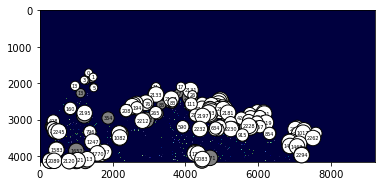

In [20]:
plot_t_tp1(growing_tips[t],growing_tips[t],poss[t],poss[tp1],final_pictures[t],final_pictures[tp1],compress=5,)

In [ ]:
t=3
tp1=t+1
plot_t_tp1([2180],[2180],poss[t],poss[tp1],final_pictures[t],final_pictures[tp1],compress=5,)

In [ ]:
plot_t_tp1(degree3_nodes[t],degree3_nodes[tp1],poss[t],poss[tp1],final_pictures[t],final_pictures[tp1],compress=5)

In [17]:
def make_growth_picture_per_tip(pixels_from_tip,pos,shape=(20700,45600),factor=10,max_growth=200,min_growth=10,per_tip=True):
    final_picture = np.zeros(shape=(shape[0]//factor,shape[1]//factor))
    number_tips = np.zeros(shape=(shape[0]//factor,shape[1]//factor))
    for tip in pixels_from_tip.keys():
        growth=pixels_from_tip[tip]
        x=min(round(pos[tip][0]/factor),shape[0]//factor-1)
        y=min(round(pos[tip][1]/factor),shape[1]//factor-1)
        if growth<=max_growth:
#             print(number_tips)
            if growth>=min_growth:
                number_tips[x,y]+=1
                final_picture[x,y]+=growth
#         print(growth,beginx,endx)    
#     for x in range(shape[0]//factor):
#         if x%1==0:
#             print(x/2070)
#         for y in range(shape[1]//factor):
#             beginx = x*factor
#             endx=(x+1)*factor
#             beginy = y*factor
#             endy=(y+1)*factor
#             tips_in_frame = [tip for tip in pixels_from_tip.keys() if (beginx<pos[tip][0]<endx) and (beginy<pos[tip][1]<endy)]
#             #shouls be improved, len is not a good indicator of actual length...
#             growth_in_frame = [len(pixels_from_tip[tip]) for tip in tips_in_frame]
#             final_picture[x,y]=np.mean(growth_in_frame)
    if per_tip:
        return(final_picture/(number_tips+(number_tips==0).astype(np.int)),number_tips)
    else:
        return(final_picture,number_tips)

In [19]:
final_pictures_growth = [np.log(make_growth_picture_per_tip(growths[i],poss[i],factor=500,max_growth=4000,per_tip=True,min_growth=0)[0]+1) for i in range (len(growths))]


In [27]:
images = []
for i,picture in enumerate(final_pictures_growth):
    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)
    ax.imshow(picture)
    bbox_time = dict(boxstyle="square", fc="black")
    ax.text(0.90, 0.90, f'{4*i}h',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=ax.transAxes,color='white',size=10*1.5,bbox=bbox_time)
    plt.savefig(f'Data/video_test/growth_timestep_{i}.png')
    plt.close(fig)
    images.append(imageio.imread(f'Data/video_test/growth_timestep_{i}.png'))
imageio.mimsave('Data/video_test/movie_growth.gif', images,duration=1)

In [44]:
paths=[]
i=5
for node in origins[i]:
    node_interest=node
    pos_problem=poss[i][node_interest]
    xbegin=pos_problem[0]-500 
    ybegin=pos_problem[1]-500
    xend=pos_problem[0]+500 
    yend=pos_problem[1]+500
    kernel = np.ones((5,5),np.uint8)
    skeleton_small1=skeletons[i][xbegin:xend,ybegin:yend]
    skeleton_small1=cv2.dilate(skeleton_small1.todense().astype(np.uint8),kernel,iterations = 1)
    skeleton_small2=skeletons[i+1][xbegin:xend,ybegin:yend]
    skeleton_small2=cv2.dilate(skeleton_small2.todense().astype(np.uint8),kernel,iterations = 1)
    path = f'Data/video_test/network_timestep_{i}_{node}'
    pipeline.paths.append(path)
    plot_t_tp1(origins[i],anastomosiss[i],poss[i],poss[i+1],skeleton_small1,skeleton_small2,
               relabel_tp1=lambda node : find_origin_tip(node,connections[i]), shift=(xbegin,ybegin), save=path,time=f't={4*i}h')
images = []
for path in paths:
    images.append(imageio.imread(path+'.png'))
imageio.mimsave(f'Data/video_test/{plate}_anastomosi_movie{i}.gif', images,duration=2)

In [20]:


node_interest=60
pos_problem=poss[0][node_interest]
xbegin=pos_problem[0]-1500
ybegin=pos_problem[1]-1500
xend=pos_problem[0]+1500
yend=pos_problem[1]+1500
skeletons_small=[]
for skeleton in skeletons:
    skeletons_small.append(skeleton[xbegin:xend,ybegin:yend])
node_smalls=[]
for i,nx_graph in enumerate(nx_graph_clean):
    node_smalls.append([node for node in nx_graph.nodes if (xbegin<poss[i][node][0]<xend and ybegin<poss[i][node][1]<yend and nx_graph.degree(node)>=1)])
kernel = np.ones((5,5),np.uint8)
skeletons_small_dilated=[cv2.dilate(skeleton.todense().astype(np.uint8),kernel,iterations = 1) for skeleton in skeletons_small]
for tp1 in range(len(growths)):
    plot_t_tp1(node_smalls[tp1],node_smalls[tp1],poss[tp1],poss[tp1],skeletons_small_dilated[tp1],skeletons_small_dilated[tp1],shift=(xbegin,ybegin),
               save=f'Data/video_test/network_timestep_{tp1}',time=f't={4*tp1}h')
images = []
for t in range(len(growths)):
    images.append(imageio.imread(f'Data/video_test/network_timestep_{t}.png'))
imageio.mimsave(f'Data/video_test/{node_interest}movie.gif', images,duration=1)

KeyError: 2140

In [19]:
node_interest=60
pos_problem=[poss[i][node_interest] for i in range(len(poss))]
xbegin=[pos_problem[i][0]-1500 for i in range(len(poss))]
ybegin=[pos_problem[i][1]-1500 for i in range(len(poss))]
xend=[pos_problem[i][0]+1500 for i in range(len(poss))]
yend=[pos_problem[i][1]+1500 for i in range(len(poss))]
skeletons_small=[]
for i,skeleton in enumerate(skeletons):
    skeletons_small.append(skeleton[xbegin[i]:xend[i],ybegin[i]:yend[i]])
node_smalls=[]
for i,nx_graph in enumerate(nx_graph_clean):
    node_smalls.append([node for node in nx_graph.nodes if (xbegin[i]<poss[i][node][0]<xend[i] and ybegin[i]<poss[i][node][1]<yend[i] and nx_graph.degree(node)>=1)])
kernel = np.ones((5,5),np.uint8)
skeletons_small_dilated=[cv2.dilate(skeleton.todense().astype(np.uint8),kernel,iterations = 1) for skeleton in skeletons_small]
for tp1 in range(len(growths)):
    plot_t_tp1(node_smalls[tp1],node_smalls[tp1],poss[tp1],poss[tp1],skeletons_small_dilated[tp1],skeletons_small_dilated[tp1],shift=(xbegin[tp1],ybegin[tp1]),save=f'Data/video_test/network_timestep_{tp1}',time=f't={4*tp1}h')
images = []
for t in range(len(growths)):
    images.append(imageio.imread(f'Data/video_test/network_timestep_{t}.png'))
imageio.mimsave(f'Data/video_test/{node_interest}movie_track.gif', images,duration=1)

In [24]:
def plot_t_tp1(node_list_t,node_list_tp1,pos_t,pos_tp1,imt,imtp1,relabel_t=lambda x:x,relabel_tp1=lambda x:x, shift=(0,0),compress=1,save='',time=None):
    left, width = .25, .5
    bottom, height = .25, .5
    right = 0.90
    top = 0.90
    if len(save)>=1:
        fig=plt.figure(figsize=(14,12))
        size = 10
    else:
        fig = plt.figure()
        size = 5
    ax = fig.add_subplot(111)
    ax.imshow(imtp1, cmap='gray',interpolation='none')
    ax.imshow(imt, cmap='jet', alpha=0.5,interpolation='none')
    bbox_time = dict(boxstyle="square", fc="black")
    bbox_props1 = dict(boxstyle="circle", fc="grey")
    bbox_props2 = dict(boxstyle="circle", fc="white")

    for node in node_list_t:
        t = ax.text((pos_t[node][1]-shift[1])//compress, (pos_t[node][0]-shift[0])//compress, str(relabel_t(node)), ha="center", va="center",
                    size=size,
                    bbox=bbox_props1)
    for node in node_list_tp1:
        if node in pos_tp1.keys():
            t = ax.text((pos_tp1[node][1]-shift[1])//compress, (pos_tp1[node][0]-shift[0])//compress, str(relabel_tp1(node)), ha="center", va="center",
                        size=size,
                        bbox=bbox_props2)
    ax.text(right, top, time,
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=ax.transAxes,color='white',size=size*1.5,bbox=bbox_time)
    if len(save)>=1:
        plt.savefig(save)
        plt.close(fig)
    else:
        plt.show()

In [158]:
growths = [[np.log(len(growth)+1) for growth in growth_pat.values() if len(growth)+1>=10] for growth_pat in growth_pattern]

(array([[ 64.,  32.,  20.,  19.,  22.,  22.,   6.,   4.,   1.,   1.],
        [101.,  25.,  20.,  10.,  26.,  30.,   5.,   8.,   0.,   1.],
        [144.,  42.,  17.,  24.,  22.,  42.,  17.,   4.,   1.,   0.],
        [118.,  42.,  23.,  22.,  21.,  44.,  16.,   2.,   1.,   0.]]),
 array([2.30258509, 2.89764935, 3.4927136 , 4.08777786, 4.68284211,
        5.27790637, 5.87297062, 6.46803488, 7.06309914, 7.65816339,
        8.25322765]),
 <a list of 4 BarContainer objects>)

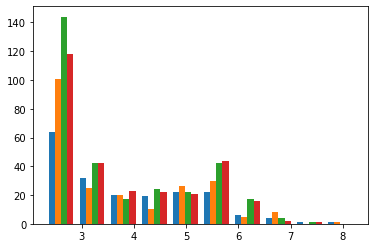

In [159]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.hist(growths,10)